# Spatial integration and clustering

STAligner is designed for alignment and integration of spatially resolved transcriptomics data.

STAligner first normalizes the expression proﬁles for all spots and constructs a spatial neighbor network using the spatial coordinates. STAligner further employs a graph attention auto-encoder neural network to extract spatially aware embedding, and constructs the spot triplets based on current embeddings to guide the alignment process by attracting similar spots and discriminating dissimilar spots across slices. STAligner introduces the triplet loss to update the spot embedding to reduce the distance from the anchor to positive spot, and increase the distance from the anchor to negative spot. The triplet construction and auto-encoder training are optimized iteratively until batch-corrected embeddings are generated. STAligner can be applied to integrate ST datasets to achieve alignment and simultaneous identification of spatial domains from different biological samples in (a), technological platforms (I), developmental (embryonic) stages (II), disease conditions (III) and consecutive slices of a tissue for 3D slice alignment (IV

Zhou, X., Dong, K. & Zhang, S. Integrating spatial transcriptomics data across different conditions, technologies and developmental stages. Nat Comput Sci 3, 894–906 (2023). https://doi.org/10.1038/s43588-023-00528-w

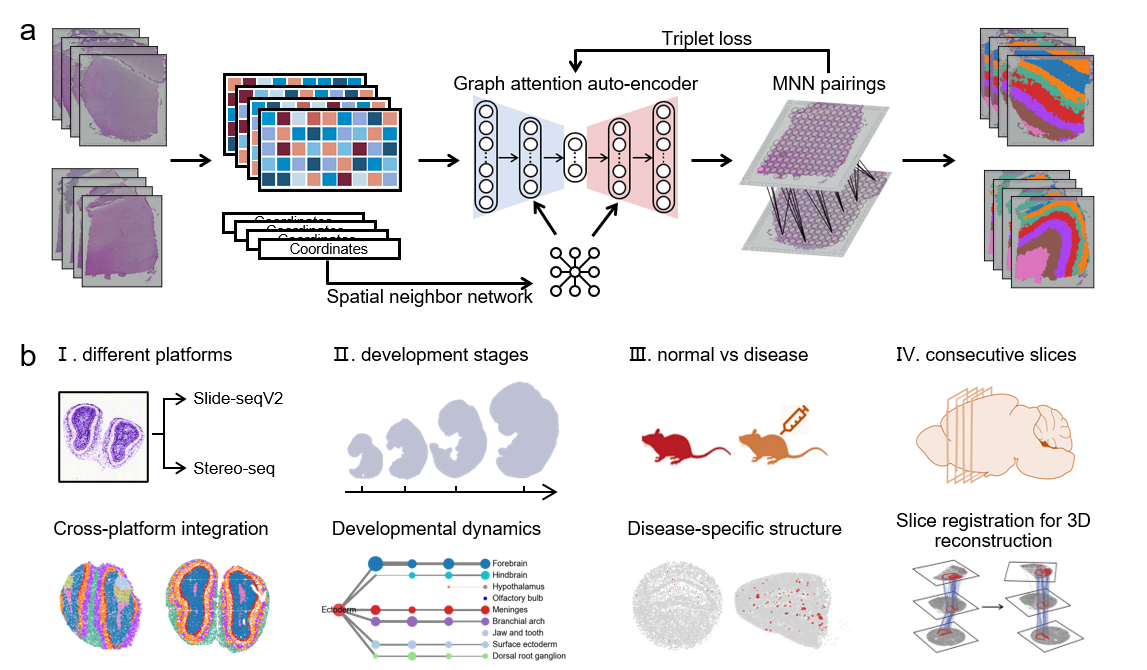).

In [1]:
from scipy.sparse import csr_matrix
import omicverse as ov
import scanpy as sc
import anndata as ad
import os

ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.4, Tutorials: https://omicverse.readthedocs.io/


# Preprocess data

Here, We use the mouse olfactory bulb data generated by Stereo-seq and Slide-seqV2. The processed Stereo-seq and Slide-seqV2 data can be downloaded from https://drive.google.com/drive/folders/1Omte1adVFzyRDw7VloOAQYwtv_NjdWcG?usp=share_link. and the original tutorals can be finded from https://staligner.readthedocs.io/en/latest

Here is a critical point that must be clarified: for STAligner, it first calculates highly variable genes before concating annadata samples. Therefore, the number of highly variable genes should not be selected too low. Otherwise, in the case of a large number of samples, the downstream features for STAligner training would be insufficient, impacting the model's performance.


In [2]:
Batch_list = []
adj_list = []
section_ids = ['Slide-seqV2_MoB', 'Stereo-seq_MoB']
print(section_ids)
pathway = '/storage/zengjianyangLab/hulei/scRNA-seq/scripts/STAligner'

for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad(os.path.join(pathway,section_id+".h5ad"))
    adata.X = csr_matrix(adata.X)
    adata.var_names_make_unique(join="++")

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]

    # Constructing the spatial network
    ov.space.Cal_Spatial_Net(adata, rad_cutoff=50) # the spatial network are saved in adata.uns[‘adj’]

    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    adata = adata[:, adata.var['highly_variable']]
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)


['Slide-seqV2_MoB', 'Stereo-seq_MoB']
Slide-seqV2_MoB
------Calculating spatial graph...
The graph contains 228288 edges, 20139 cells.
11.3356 neighbors per cell on average.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
Stereo-seq_MoB
------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (ad

In [3]:
Batch_list

[View of AnnData object with n_obs × n_vars = 20139 × 10000
     var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'Spatial_Net', 'adj', 'hvg', 'log1p'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 19109 × 10000
     var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'Spatial_Net', 'adj', 'hvg', 'log1p'
     obsm: 'spatial']

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (39248, 3402)


# Training STAligner model

Here, we used `ov.space.pySTAligner` to construct a STAGATE object to train the model.

We are using the `train_STAligner_subgraph` function from STAligner to reduce GPU memory usage, each slice is considered as a subgraph for training.

In [5]:
%%time
# iter_comb is used to specify the order of integration. For example, (0, 1) means slice 0 will be algined with slice 1 as reference.
iter_comb = [(i, i + 1) for i in range(len(section_ids) - 1)]

# Here, to reduce GPU memory usage, each slice is considered as a subgraph for training.
STAligner_obj = ov.space.pySTAligner(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 600, iter_comb = iter_comb,
                                     batch_key = 'batch_name',  key_added='STAligner', Batch_list = Batch_list)

STAligner(
  (conv1): GATConv(3402, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 3402, heads=1)
)
CPU times: user 1.44 s, sys: 714 ms, total: 2.15 s
Wall time: 1.73 s


In [6]:
STAligner_obj.train()

Pretrain with STAGATE...


100%|██████████| 500/500 [02:21<00:00,  3.54it/s]


Train with STAligner...


  0%|          | 0/100 [00:00<?, ?it/s]

Update spot triplets at epoch 500


100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


We stored the latent embedding in `adata.obsm['STAligner']`.

In [7]:
adata = STAligner_obj.predicted()

# Clustering the space

We can use `GMM`, `leiden` or `louvain` to cluster the space.

`ov.utils.cluster(adata,use_rep='STAligner',method='GMM',n_components=7,covariance_type='full', tol=1e-9, max_iter=1000, random_state=3607`

or `sc.pp.neighbors(adata, use_rep='STAligner', random_state=666)`            
`ov.utils.cluster(adata,use_rSTAlignerGATE',method='leiden',resolution=1)`

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


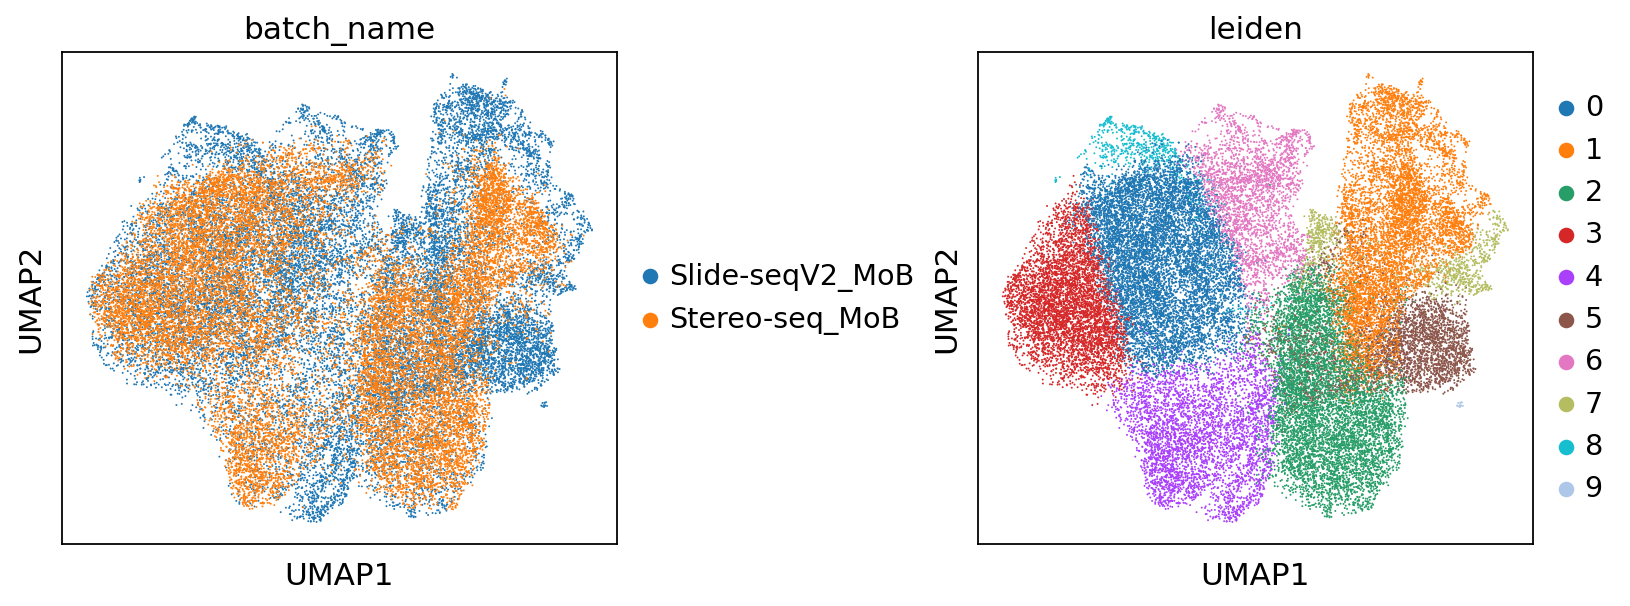

In [8]:
sc.pp.neighbors(adata, use_rep='STAligner', random_state=666)
ov.utils.cluster(adata,use_rep='STAligner',method='leiden',resolution=0.4)
sc.tl.umap(adata, random_state=666)
sc.pl.umap(adata, color=['batch_name',"leiden"],wspace=0.5)


We can also map the clustering results back to the original spatial coordinates to obtain spatially specific clustering results.

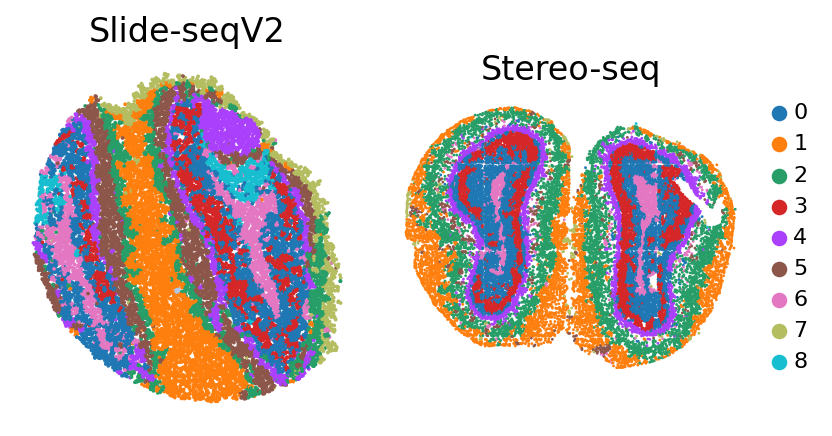

In [9]:

import matplotlib.pyplot as plt
spot_size = 50
title_size = 15
fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.2})
_sc_0 = sc.pl.spatial(adata[adata.obs['batch_name'] == 'Slide-seqV2_MoB'], img_key=None, color=['leiden'], title=['Slide-seqV2'],
                      legend_fontsize=10, show=False, ax=ax[0], frameon=False, spot_size=spot_size, legend_loc=None)
_sc_0[0].set_title('Slide-seqV2', size=title_size)

_sc_1 = sc.pl.spatial(adata[adata.obs['batch_name'] == 'Stereo-seq_MoB'], img_key=None, color=['leiden'], title=['Stereo-seq'],
                      legend_fontsize=10, show=False, ax=ax[1], frameon=False, spot_size=spot_size)
_sc_1[0].set_title('Stereo-seq',size=title_size)
_sc_1[0].invert_yaxis()
plt.show()